# Gradient Based Optimization


## Gradient decent method    

The general framework for a gradient method for finding a minimizer of a function $f$ is defined by
\begin{align*} 
x^{k+1} = x^{(k)} -\alpha_k \nabla f(x_k), \ \ \ \ \ \ \  k=0, 1, 2, ...
\end{align*} 
where $\alpha_k \gt 0$ is known as the step size or learning rate.    


In linear regression, the critical point has a closed-form solution. But that's not always the case especially for complicated functions. Thus, gradient decent is often used in machine learning.     

From notebook 01, the gradient (first order derivative) is
$$
\nabla_\beta L(\beta) = -2 X^T y + 2X^TX\beta, 
$$

The weight vector can be iteratively updated by doing:
$$
\hat{\beta}^{(k+1)} = \hat{\beta}^{(k)} - \eta \nabla_{\beta} L(\hat{\beta}^{(k)}).
$$


First, generate some synthetic data:


In [1]:
import numpy as np
np.random.seed(8964)

n = 200                                                       # number of samples
# dimension of problem
p = 6
# noise standard deviation
sigma = 0.2
X = np.random.normal(0, 1, size=(n, p))                       # design matrix
beta_star = np.random.randint(-4, 2, p)                       # true beta
noise = np.random.normal(0, sigma, size=(n))
y = X @ beta_star + noise                                     # y values


#### Weight vector $\beta$ closed-form solution     

From notebook 01:
$$
\hat{\beta} = (X^TX)^{-1}X^T y.
$$


In [2]:
beta_hat_np = np.linalg.inv(X.T @ X) @ X.T @ y
print("beta hat using numpy:  ", beta_hat_np)
print("           true beta:  ", beta_star)


beta hat using numpy:   [-1.0202166  -2.99123646 -1.00450705 -1.97897081 -1.00582651 -2.01509766]
           true beta:   [-1 -3 -1 -2 -1 -2]


#### Solve with `sklearn`


In [3]:
from sklearn.linear_model import LinearRegression
beta_hat_sk = LinearRegression(fit_intercept=False).fit(X, y).coef_
print("beta hat using sklearn:  ", beta_hat_sk)
print("             true beta:  ", beta_star)


beta hat using sklearn:   [-1.0202166  -2.99123646 -1.00450705 -1.97897081 -1.00582651 -2.01509766]
             true beta:   [-1 -3 -1 -2 -1 -2]


#### Gradient decent(GD)    

Take $\eta=0.001$ as the step size (learning rate), and run GD T=50 iterations.

As mentioned before, the gradient is
$$
\nabla_\beta L(\beta) = -2 X^T y + 2X^TX\beta, 
$$


In [4]:
eta = 0.001
T = 50


def grad_loss(b, X, y):
    return -2 * X.T @ y + 2 * X.T @ X @ b


# store the beta vec at each iteration
betas = np.zeros(shape=(T, p))

for t in range(1, T):
    betas[t, :] = betas[t-1, :] - eta * grad_loss(betas[t-1, :], X, y)

print("beta hat using GD by hand:  ", betas[T-1, :])
print("                true beta:  ", beta_star)


beta hat using GD by hand:   [-1.02021658 -2.99123644 -1.00450708 -1.97897079 -1.00582652 -2.01509767]
                true beta:   [-1 -3 -1 -2 -1 -2]


#### GD with `PyTorch`

PyTorch is technically an `automatic differentiation (autodiff)` library, which means that it is able to compute gradients of functions numerically. PyTorch is primarily used for deep learning (which requires a form of differentiation called 'back propagation'). 

In `PyTorch` tensors are used rather than `NumPy` arrays. You can think of tensors as you do arrays, the only difference is that tensors allow you to compute gradients. It is important to note here that in the following code, there is no equivalent of the `grad_loss` function, which is taken care of automatically (by the `autodiff` ).


In [5]:
import torch
# X data tensor
X_tensor = torch.from_numpy(X).float()
# y data tensor
y_tensor = torch.from_numpy(y).float()
# this is our parameter vector beta
beta_tensor = torch.zeros(p, requires_grad=True)
eta = 0.1
T = 50

for _ in range(T):
    yhat = X_tensor @ beta_tensor             # prediction of model
    residual = yhat - y_tensor                # residual tensor (errors)
    loss = (residual**2).mean()               # mean squared error tensor

    # this call computes gradients of `loss` w.r.t. any params (beta)tensor
    loss.backward()

    with torch.no_grad():
        # we do not want this calculation to be part of the gradient computation
        beta_tensor -= eta * beta_tensor.grad

    # remove current gradients from being stored (important if you want to recompute gradients)
    beta_tensor.grad.zero_()

print("beta hat using PyTorch:  ", beta_tensor.data)
print("             true beta:  ", beta_star)


beta hat using PyTorch:   tensor([-1.0200, -2.9910, -1.0046, -1.9788, -1.0057, -2.0151])
             true beta:   [-1 -3 -1 -2 -1 -2]


#### GD with `PyTorch` a better way    

Make use of more `PyTorch` functionality.   

General procedures:
1. For any problem you wish to solve using `PyTorch`, you should first specify a `model` which inherits from the `Module` class and defines the model of computation you wish to work with. Importantly, this class always contains a `forward` function that describes how an input should make its way through the computational graph.

2. `PyTorch` already has a host of useful machine learning functions that can be imported. Many of these live in the `nn` module, which is short for `neural nets`.

3. `PyTorch` already has a large number of optimizers (other numerical methods apart from GD) that we can use. These live in the `optim` module


In [6]:
from torch import nn, optim

# create the linear regression model class


class LinearRegressionTorch(nn.Module):
    def __init__(self):
        super().__init__()

        # need to wrap the params of the model in nn.Parameter
        self.beta_tensor = nn.Parameter(torch.zeros(p, requires_grad=True))

    def forward(self, X):
        return X @ self.beta_tensor


model = LinearRegressionTorch()                        # create a model instance
loss_func = nn.MSELoss()                               # choose MSE loss
optimizer = optim.SGD(model.parameters(), lr=eta)      # choose Stochastic GD

for _ in range(50):
    yhat = model.forward(X_tensor)
    loss = loss_func(y_tensor, yhat)
    loss.backward()
    optimizer.step()                                   # no need to manually update
    optimizer.zero_grad()

print("beta hat using PyTorch w model:  ", model.beta_tensor.data)
print("                     true beta:  ", beta_star)


beta hat using PyTorch w model:   tensor([-1.0200, -2.9910, -1.0046, -1.9788, -1.0057, -2.0151])
                     true beta:   [-1 -3 -1 -2 -1 -2]


### Gradient based optimization on Ridge model     

Consider optimizing the following loss function of ridge model (w.r.t.  $x$):
$$
f(x)=\frac{1}{2}\|Ax-b\|_2^2+\frac{\gamma}{2}\|x\|^2_2
$$
and where $A\in \mathbb{R}^{m\times n}, b\in \mathbb{R}^m$ are defined as

\begin{align*}
A=\left [
    \begin{array}{cccc}
    1&2&1&-1 \\
    -1&1&0&2 \\
    0&-1&-2&1 \\
    \end{array}
\right ]
, \ \ \ \ \ \ 
b = \left [
    \begin{array}{c}
    3\\ 2\\ -2\\
    \end{array}
\right ]
\end{align*}

$\gamma$ is a positive constant.    
Run gradient decent on $f$ with step size $\alpha = 0.1$, $\gamma = 0.2$, and starting point of $x^{(0)}=(1, 1, 1, 1)$. 

Terminate the algorithm when $\|\nabla f(x^{(k)})\|_2 \lt 0.001$.


The gradient is 
\begin{align*}
\nabla f(x) &= \frac{\partial}{\partial x}f(x) = A^TAx-A^Tb+\gamma x
\end{align*}
So the GD steps are
\begin{align*}
x^{(k+1)} &= x^{(k)} - \alpha_k(A^TAx^{(k)}-A^Tb+\gamma x^{(k)}) \\ 
&= x^{(k)} - \alpha_k(A^T(Ax^{(k)}-b)+\gamma x^{(k)}) \\ 
\end{align*}


In [7]:
# Solve manually
A = np.array([
    [1, 2, 1, -1],
    [-1, 1, 0, 2],
    [0, -1, -2, 1]
])
b = np.array([3, 2, -2])
gamma = 0.2
alpha = 0.1
tol = 0.001


def grad_f(x):
    return A.T @ (A@x - b) + gamma * x


x = np.array([1, 1, 1, 1])
k = 0
x_k = [x]
while np.linalg.norm(grad_f(x)) > tol:
    x = x - alpha * grad_f(x)
    k += 1
    x_k.append(x)

print("First 5 iterations: ")
for i in range(6):
    print(f"k={i},\t{x_k[i]}")

print("Last 5 iterations: ")
for i in range(5):
    print(f"k={k - 4 + i},\t{x_k[k - 4 + i]}")


First 5 iterations: 
k=0,	[1 1 1 1]
k=1,	[0.98 0.98 0.98 0.98]
k=2,	[0.9624 0.9804 0.9744 0.9584]
k=3,	[0.942712 0.982392 0.966832 0.943272]
k=4,	[0.92337456 0.98663216 0.95983296 0.92954576]
k=5,	[0.90444937 0.99160416 0.95259323 0.91685286]
Last 5 iterations: 
k=272,	[0.06662967 1.33658172 0.49283021 0.32508074]
k=273,	[0.06655417 1.33661408 0.49278707 0.32502682]
k=274,	[0.06648018 1.33664579 0.49274479 0.32497397]
k=275,	[0.06640768 1.33667686 0.49270336 0.32492218]
k=276,	[0.06633662 1.33670732 0.49266275 0.32487142]


In [8]:
# Solve with PyTorch
from turtle import forward


A_tensor = torch.from_numpy(A).float()
b_tensor = torch.from_numpy(b).float()


class RidgeModel(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.x = nn.Parameter(torch.ones(4, requires_grad=True))

    def forward(self, A):
        return A @ self.x


model = RidgeModel()
optimizer = optim.SGD(model.parameters(), lr=alpha)

k = 0
while True:
    if k % 20 == 0:
        print(f"{k=},\t{model.x.data}")
    y = model.forward(A_tensor)
    loss = 0.5 * torch.linalg.norm(y - b_tensor, ord=2)**2 + \
        gamma * 0.5 * torch.linalg.norm(model.x, ord=2)**2
    loss.backward()
    optimizer.step()
    k += 1
    if torch.linalg.norm(model.x.grad) <= tol:
        break
    optimizer.zero_grad()

print(f"k={k},\t{model.x.data}")


k=0,	tensor([1., 1., 1., 1.])
k=20,	tensor([0.6772, 1.0758, 0.8405, 0.7608])
k=40,	tensor([0.4726, 1.1626, 0.7248, 0.6150])
k=60,	tensor([0.3364, 1.2210, 0.6470, 0.5177])
k=80,	tensor([0.2455, 1.2599, 0.5950, 0.4528])
k=100,	tensor([0.1848, 1.2860, 0.5603, 0.4095])
k=120,	tensor([0.1442, 1.3033, 0.5372, 0.3805])
k=140,	tensor([0.1172, 1.3149, 0.5217, 0.3612])
k=160,	tensor([0.0991, 1.3227, 0.5114, 0.3483])
k=180,	tensor([0.0871, 1.3278, 0.5045, 0.3397])
k=200,	tensor([0.0790, 1.3313, 0.4999, 0.3339])
k=220,	tensor([0.0736, 1.3336, 0.4968, 0.3301])
k=240,	tensor([0.0701, 1.3351, 0.4948, 0.3275])
k=260,	tensor([0.0677, 1.3361, 0.4934, 0.3258])
k=277,	tensor([0.0663, 1.3367, 0.4926, 0.3248])


#### Apply to a real world dataset `CarSeats.csv`

Contains 400 observations with each observation describing child car seats for sale at one of 400 stores. 

The features in the data set are outlined below:
* Sales: Unit sales (in thousands) at each location
* CompPrice: Price charged by competitor at each location
* Income: Local income level (in thousands of dollars)
* Advertising: advertising budget (in thousands of dollars)
* Population: local population size (in thousands)
* Price: price charged by store at each site
* ShelveLoc: A categorical variable with Bad, Good and Medium describing the quality of the
* elf location of the car seat
* Age: Average age of the local population
* Education: Education level at each location
* Urban A categorical variable with levels No and Yes to describe whether the store is in an
* ban location or in a rural one
* US: A categorical variable with levels No and Yes to describe whether the store is in the US or
not.

The target variable is Sales. The goal is to learn to predict the amount of Sales as a function of a
subset of the above features.


Recall Ridge Regression: 
$$\hat{\beta}_{\text{Ridge}} = \arg \min_{\beta} \frac{1}{n}\|y-X \beta\|^2_2 + \phi \| \beta \|_2^2$$
where $\beta \in \mathbb{R}^p, X \in \mathbb{R}^{n\times p}$, and $\phi \gt 0$.


Data preprocessing    
* Remove categorical features
* Standardize features and center the target variable (subtract its mean).
* Create training set from the first half of the resulting dataset, and a test set from the remaining half and call these objects X train, X test, Y train and Y test.


In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("data/CarSeats.csv")
df = df.drop(columns=['ShelveLoc', 'Urban', 'US'])
df.describe()


,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000


In [10]:
X = df.iloc[:, 1:]
Y = df.iloc[:, 0]
Y = Y - Y.mean()
scaled_X = StandardScaler().fit_transform(X)
print(f"Feature Means: {scaled_X.mean(axis=0)}")
print(f"Feature Variances: {scaled_X.var(axis=0)}")

split_point = scaled_X.shape[0] // 2
X_train = scaled_X[:split_point]
X_test = scaled_X[split_point:]
Y_train = Y[:split_point].to_numpy()
Y_test = Y[split_point:].to_numpy()

print('first row X_train:', np.round(X_train[0], 4))
print('last  row X_train:', np.round(X_train[-1], 4))
print('first row  X_test:', np.round(X_test[0], 4))
print('last  row  X_test:', np.round(X_test[-1], 4))
print('first row Y_train:', np.round(Y_train[0], 4))
print('last  row Y_train:', np.round(Y_train[-1], 4))
print('first row  Y_test:', np.round(Y_test[0], 4))
print('last  row  Y_test:', np.round(Y_test[-1], 4))


Feature Means: [ 3.81916720e-16  3.55271368e-17  2.66453526e-17  1.59872116e-16
 -6.21724894e-17  1.28785871e-16 -1.33226763e-16]
Feature Variances: [1. 1. 1. 1. 1. 1. 1.]
first row X_train: [ 0.8505  0.1554  0.6572  0.0758  0.1778 -0.6998  1.1844]
last  row X_train: [-0.1942  0.692  -0.2462  0.4767  0.4316  0.6599  0.0382]
first row  X_test: [ 1.2422  0.8351 -0.9989  0.5718  1.2773  0.5363 -0.726 ]
last  row  X_test: [ 0.5893 -1.1326 -0.9989 -1.6158  0.1778 -0.2672  0.8024]
first row Y_train: 2.0037
last  row Y_train: -1.0763
first row  Y_test: -1.9363
last  row  Y_test: 2.2137


The closed-form for $\hat{\beta}_{Ridge}$:
$$
\hat{\beta}_{Ridge} = ((\frac{1}{n})X^TX+\phi I)^{-1}(\frac{1}{n})X^Ty
$$


In [11]:
from sklearn.linear_model import Ridge
n = X_train.shape[0]
p = X_train.shape[1]
phi = 0.5
beta_ridge = (1 / n * X_train.T @ Y_train) @ np.linalg.inv(1 /
                                                           n * X_train.T @ X_train + phi * np.identity(p))
print(f"beta_ridge = {np.round(beta_ridge, 4)}")

# Check with sklearn
model = Ridge(alpha=0.5*n).fit(X_train, Y_train)
print("sklearn:    ", np.round(model.coef_, 4))


beta_ridge = [ 0.6807  0.2823  0.6516  0.0083 -1.1713 -0.4009 -0.1006]
sklearn:     [ 0.68    0.2837  0.65    0.0077 -1.1717 -0.4    -0.0996]


#### Variants of Gradient Descent

##### (i) Batch gradient descent (GD):
Calculate the average gradient for all n data and update the gradient in one pass:
$$
\beta^{k+1} = \beta^k - \frac{\alpha_k}{n}\sum^{n}_{i=1}\nabla L_i(\beta^{(k)})
$$

##### (ii) Stochastic Gradient Descent (SGD)

Instead of considering all n terms, at the k-th step randomly choose an index $i_k$ from $\{1, ..., n\}$ and update:
$$
\beta^{k+1} = \beta^k - \alpha_k\nabla L_i(\beta^{(k)})
$$

##### (iii) Mini-Batch Gradient Descent

GD (using all data) and SGD (using a single record) represents the two possible extremes. Mini-batch GD chooses a batch size $1\lt B \lt n$ at each step and update the weights with the gradient generated from the mini batch:
$$
\beta^{k+1} = \beta^k - \frac{\alpha_k}{B}\sum^{B}_{j=1}\nabla L_{i_j}(\beta^{(k)})
$$
Still approximate the full gradient but using more than a single element as in SGD.


#### GD and Ridge      

Let $\beta^{(0)}=\mathbb{1}_p$ and $\phi=0.5$, and run the GB for 1000 epochs.
Run the experiment with the following learning rate:
$$
\alpha \in \{0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01\}
$$
To monitor the performance of the algorithm, record the value 
$$
\Delta^{(k)}=L(\beta^{(k)}) - L(\hat{\beta})
$$
where $\hat{\beta}$ is the true (closed form) solution derived earlier.


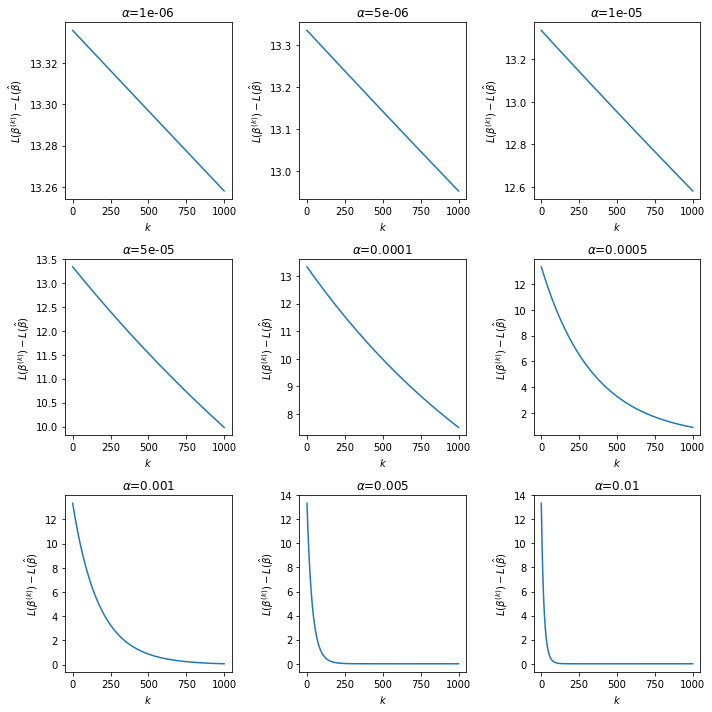

alpha=0.01 train MSE:  4.55890672455346
alpha=0.01 test MSE:  4.380429183357875


In [32]:
import matplotlib.pyplot as plt
phi = 0.5
n = X_train.shape[0]
p = X_train.shape[1]
n_epochs = 1000
alphas = [0.000001, 0.000005, 0.00001, 0.00005,
          0.0001, 0.0005, 0.001, 0.005, 0.01]


def loss(beta, X, y):
    return (1/n) * np.linalg.norm(y-X@beta)**2 + phi * np.linalg.norm(beta)**2


def gradient(beta, X, y):
    return -(2/n) * X.T @ (y - X @ beta) + 2 * phi * beta


fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    betas = np.zeros((n_epochs, p))
    betas[0] = np.ones(p)
    loss_diffs = np.ones(n_epochs) * np.inf
    loss_diffs[0] = loss(betas[0], X_train, Y_train) - \
        loss(beta_ridge, X_train, Y_train)
    alpha = alphas[i]
    for j in range(1, n_epochs):
        betas[j] = betas[j - 1] - alpha * \
            gradient(betas[j - 1], X_train, Y_train)
        loss_diffs[j] = loss(betas[j], X_train, Y_train) - \
            loss(beta_ridge, X_train, Y_train)
    ax.plot(np.arange(n_epochs), loss_diffs)
    ax.set_title(rf'$\alpha$={alpha}')
    ax.set_ylabel(r'$L(\beta^{(k)}) - L(\hat{\beta})$')
    ax.set_xlabel(rf'$k$')
plt.tight_layout()
plt.show()


def MSE(beta, X, y):
    n = X.shape[0]
    return (1/n) * np.linalg.norm(y - X@beta) ** 2

# best learning rate 0.01
print("alpha=0.01 train MSE: ", MSE(betas[-1], X_train, Y_train))
print("alpha=0.01 test MSE: ", MSE(betas[-1], X_test, Y_test))


#### SGD and Ridge     

Expend the loss function of ridge:
\begin{align*}
L(\beta)&=\frac{1}{n}\|y-X\beta\|^2_2+\phi\|\beta\|^2_2 \\
&= \frac{1}{n} \sum_{i=1}^{n}(y_i-x_i^T\beta)^2+ \phi\|\beta\|^2_2 \\
&= \frac{1}{n}\sum_{i=1}^{n} [(y_i-x_i^T\beta)^2+ \phi \|\beta\|^2_2] \\
&= \frac{1}{n}\sum_{i=1}^{n}L_i(\beta)
\end{align*}
Here we merge $n$ and $\phi$ for simpler expression since $\phi$ is just a hyperparameter.
Then the gradient is:
\begin{align*}
\nabla L_i(\beta) = -2x_i(y_i-x_i^T\beta)+2\phi\beta
\end{align*}
The settings are the same as GD but only run SGD for 5 epochs and with a new learning rate list: 
$$
\alpha \in \{0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.006, 0.02\}
$$


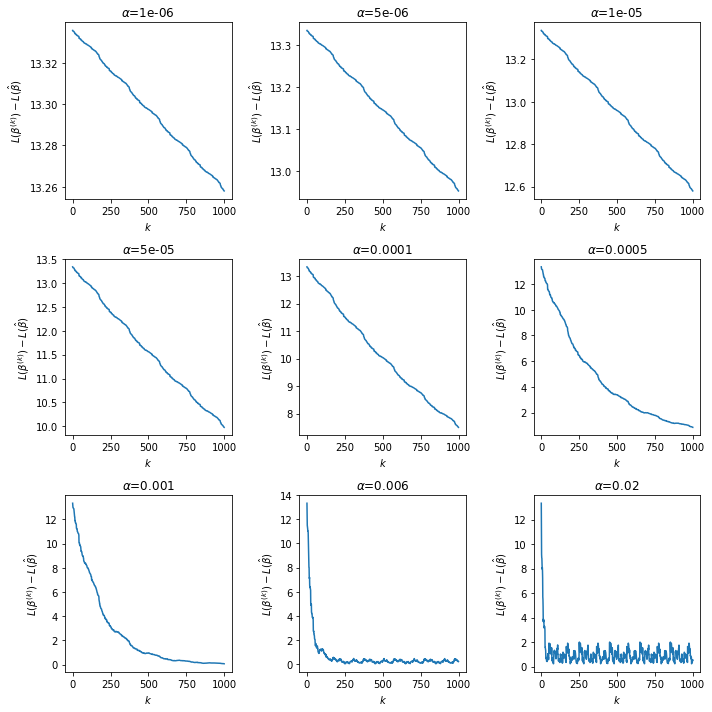

alpha=0.006 train MSE:  4.6617491126098445
alpha=0.006 test MSE:  4.447228959826241


In [31]:
phi = 0.5
n = X_train.shape[0]
p = X_train.shape[1]
n_epochs = 5
n_iter = n_epochs * n   # total number of updates
alphas = [0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.006, 0.02]


def gradient_i(beta, xi, yi):
    return -2 * xi * (yi - np.dot(xi, beta)) + 2 * phi * beta #* n


fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    betas = np.zeros((n_iter, p))
    betas[0] = np.ones(p)
    loss_diffs = np.ones(n_iter) * np.inf
    loss_diffs[0] = loss(betas[0], X_train, Y_train) - loss(beta_ridge, X_train, Y_train)
    alpha = alphas[i]
    for j in range(1, n_iter):
        idx = j % n
        betas[j] = betas[j-1] - alpha * gradient_i(betas[j-1], X_train[idx], Y_train[idx])
        loss_diffs[j] = loss(betas[j], X_train, Y_train) - loss(beta_ridge, X_train, Y_train)
    ax.plot(np.arange(n_iter), loss_diffs)
    ax.set_title(rf'$\alpha$={alpha}')
    ax.set_ylabel(r'$L(\beta^{(k)}) - L(\hat{\beta})$')
    ax.set_xlabel(rf'$k$')

plt.tight_layout()
plt.show()

# best learning rate is 0.001
alpha = 0.006
betas = np.zeros((n_iter, p))
betas[0] = np.ones(p)
for j in range(1, n_iter):
    idx = j % n
    betas[j] = betas[j-1] - alpha * \
        gradient_i(betas[j-1], X_train[idx], Y_train[idx])

print(f"{alpha=} train MSE: ", MSE(betas[-1], X_train, Y_train))
print(f"{alpha=} test MSE: ", MSE(betas[-1], X_test, Y_test))


GD achieves lower train and test MSE than SGD but note that in GD in the fastest converging step size case it took roughly 50 epochs to achieve the lowest error, whereas SGD converged after less than 1 epoch. 
We can therefore argue that GD is better when the n is small, and it is not too computationally costly to compute the full gradient. 
SGD is far less computationally costly but at the end of the day it requires us to use quite a crude approximation to the full gradient, and so we are not guaranteed to actually ‘descend’ on any given iteration of
the algorithm nor descent to the best possible solution.

#### Gradient decent by each feature      
In GD, SGD and mini-batch GD, we always update the entire p-dimensional vector $\beta$ at each iteration. 

An alternative approach is to update each of the p parameters individually.
Specifically, initialize $\beta^{(0)}$, then solve(for $k=1,2,3...$):
\begin{align*}
\beta^{(k)}_1 &= \arg\min_{\beta_1}L(\beta_1, \beta_2^{(k-1)}, \beta_3^{(k-1)},..., \beta_p^{(k-1)}) \\
\beta^{(k)}_2 &= \arg\min_{\beta_1}L(\beta_1^{(k-1)}, \beta_2, \beta_3^{(k-1)},..., \beta_p^{(k-1)}) \\
&...\\
\beta^{(k)}_p &= \arg\min_{\beta_1}L(\beta_1^{(k-1)}, \beta_2^{(k-1)}, \beta_3^{(k-1)},..., \beta_p) \\
\end{align*}
Each of the minimization is over a single (1-dimensional) coordinate of $\beta$, and also that as soon as $\beta^{(k)}_j$ is updated, the new value will be used to update $\beta^{(k)}_{j+1}$ and so on.
The idea is then cycle through these coordinate level updates until convergence.

Let $X$ be a $n\times p$ matrix $X=[X_1,...,X_p]$, where $X_j$ is the $j$-th column of $X$. 

Note that $X\beta = X_j\beta_j + X_{-j}\beta_{-j}$, where $X_{-j}$ denotes the matrix $X$ but with $j$-th column removed (so is $\beta_{-j}$).

\begin{align*}
L(\beta) &= \frac{1}{n}\|X\beta - Y\|_2^2+\phi \|\beta\|^2_2 \\
&= \frac{1}{n}(\beta^TX^TX\beta - 2Y^TX\beta + Y^TY)+\phi \|\beta\|^2_2 \\
&= \frac{1}{n}((X_j\beta_j+X_{-j}\beta_{-j})^T(X_j\beta_j+X_{-j}\beta_{-j}) - 2Y^T(X_j\beta_j + X_{-j}\beta_{-j}) + Y^TY)+\phi (\beta_j^2 + \sum_{i=\{1...p|i\ne j\}}\beta_i^2) \\
&= \frac{1}{n}((X_j\beta_j)^TX_j\beta_j +2(X_{-j}\beta_{-j})^TX_j\beta_j + (X_{-j}\beta_{-j})^TX_{-j}\beta_{-j}-2Y^T(X_j\beta_j+X_{-j}\beta_{-j}) + Y^TY)\\ &+ \phi\beta_j^2 +\sum_{i=\{1...p|i\ne j\}}\beta_i^2 \\
\\
\frac{\partial}{\partial \beta_j}L(\beta) &= \frac{2}{n}(X_j^TX_j\beta_j+(X_{-j}\beta_{-j})^TX_1-2Y^TX_j) + 2\phi\beta_j \\
&= \frac{2X_j^T}{n}(X_j\beta_j+X_{-j}\beta_{-j}-Y)+2\phi\beta_j
\end{align*}

Set the above to $0$, $\beta$ has a closed form solution:
$$
\hat{\beta}_j = \frac{X_j^T(y-X_{-j}\beta{-j})}{n\phi + \|X_j\|_2^2}
$$

train MSE:  4.558906730683295
test MSE:  4.380429183564441


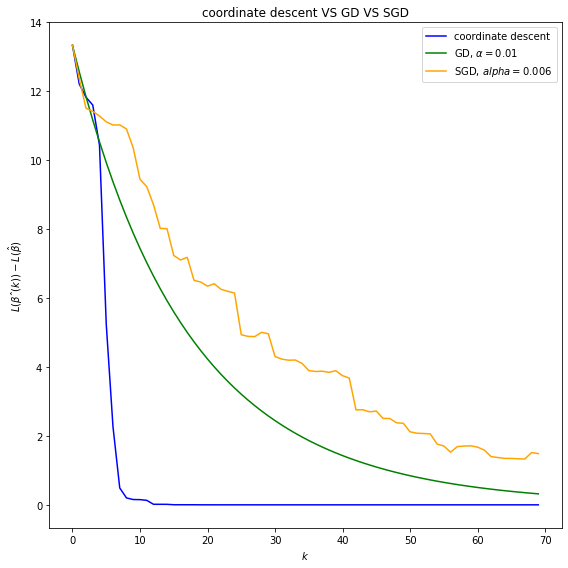

In [28]:
phi = 0.5
n = X_train.shape[0]
p = X_train.shape[1]
n_cycles = 10
n_iter = n_cycles * p
beta_star = np.linalg.inv(X_train.T @ X_train + n * phi * np.eye(p)) @ X_train.T @ Y_train


def loss(beta, X, y):
    return (1/n) * np.linalg.norm(y-X@beta)**2 + phi * np.linalg.norm(beta)**2


def beta_j_update(j, beta, X, y):
    n = X.shape[0]
    Xj = X[:, j]
    Xmj = np.delete(X, j, axis=1)
    betaj = beta[j]
    betamj = np.delete(beta, j)

    num = Xj.T @ (y - Xmj @ betamj)
    den = n * phi + np.linalg.norm(Xj)**2
    return num / den

betas = np.zeros((n_iter, p))
betas[0] = np.ones(p)
loss_diffs = np.ones(n_iter) * np.inf
loss_diffs[0] = loss(betas[0], X_train, Y_train) - loss(beta_star, X_train, Y_train)

fig = plt.figure(figsize=(8,8))
for i in range(n_iter - 1):
    idx = i % p
    betas[i+1] = betas[i]
    betas[i+1][idx] = beta_j_update(idx, betas[i+1], X_train, Y_train)
    loss_diffs[i+1] = loss(betas[i+1], X_train, Y_train) - loss(beta_star, X_train, Y_train)

plt.plot(np.arange(n_iter), loss_diffs, color='blue', label='coordinate descent')
print("train MSE: ", MSE(betas[-1], X_train, Y_train))
print("test MSE: ", MSE(betas[-1], X_test, Y_test))

# GD
n_epochs = 1000
alpha = 0.01

betas = np.zeros((n_iter, p))
betas[0] = np.ones(p)
loss_diffs_gd = np.ones(n_iter) * np.inf
loss_diffs_gd[0] = loss(betas[0], X_train, Y_train) - loss(beta_star, X_train, Y_train)
    
for j in range(1, n_iter):
    betas[j] = betas[j-1] - alpha * gradient(betas[j-1], X_train, Y_train)
    loss_diffs_gd[j] = loss(betas[j], X_train, Y_train) - loss(beta_star, X_train, Y_train)

plt.plot(np.arange(n_iter), loss_diffs_gd, color='green', label='GD, $\\alpha =0.01$')

# SGD
alpha = 0.006
betas = np.zeros((n_iter, p))
betas[0] = np.ones(p)
loss_diffs_sgd = np.ones(n_iter) * np.inf
loss_diffs_sgd[0] = loss(betas[0], X_train, Y_train) - loss(beta_star, X_train, Y_train)
for j in range(1, n_iter):
    idx = j % n
    betas[j] = betas[j-1] - alpha * gradient_i(betas[j-1], X_train[idx], Y_train[idx])
    loss_diffs_sgd[j] = loss(betas[j], X_train, Y_train) - loss(beta_star, X_train, Y_train)

plt.plot(np.arange(n_iter), loss_diffs_sgd, color='orange', label=f'SGD, $alpha={alpha}$')

plt.legend()
plt.title(rf'coordinate descent VS GD VS SGD')
plt.ylabel(r'$L(\betaˆ{(k)}) - L(\hat{\beta})$')
plt.xlabel(rf'$k$')
plt.tight_layout()
plt.show()

## Newton's Method     
GD is referred to as a first order method while Newtons's algorithm is referred to as a second order method. 
A second order method makes use of both first and second derivatives. Generally, second order methods are more accurate than first order ones. 
Given a twice differentiable function $g:\mathbb{R}\rightarrow\mathbb{R}$, Newton's method generates a sequence $\{x^{(k)}\}$ iteratively according to the following update rule:
$$
x^{(k+1)}=x^{(k)} - \frac{g'(x^{(k)})}{g''(x^{(k)})},\ \ \ \ \ \ k=0,1,2... 
$$
In practice, a different update called the *dampened* Newton method is used which is defined by: 
$$
x^{(k+1)}=x^{(k)} - \alpha\frac{g'(x^{(k)})}{g''(x^{(k)})},\ \ \ \ \ \ k=0,1,2... 
$$
Here, as in the case of GD, the step size $\alpha$ has the effect of 'dampening' the update.

Consider the function $f:\mathbb{R}\rightarrow\mathbb{R}$ defined by:
$$
f(x,y)=100(y-x^2)^2+(1-x)^2
$$
A plot of $f$:

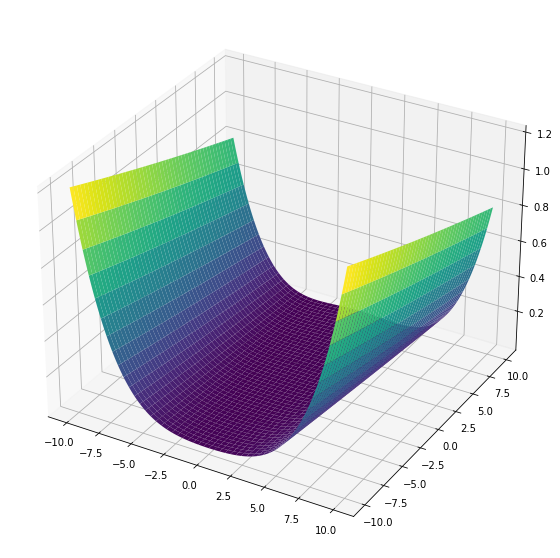

In [36]:
def func(X):
    return 100. * (X[1] - X[0] ** 2) ** 2 + (1 - X[0]) ** 2


x = np.linspace(-10, 10, 500)
y = np.linspace(-10, 10, 500)
X, Y = np.meshgrid(x, y)
fxy = func(np.array([X, Y]))

fig_f = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, fxy, cmap='viridis')
plt.show()


Calculate the first and second order derivatives (gradient and Hessian matrix):
$$
\begin{align*}
\nabla f([x,y])&=f'(x,y)=
\begin{bmatrix}
\frac{\partial}{\partial x}100(y-x^2)^2+(1-x)^2  \\
\frac{\partial}{\partial y}100(y-x^2)^2+(1-x)^2  \\
\end{bmatrix}  \\
\\
\nabla f([x,y])&=
\begin{bmatrix}
-400(y-x^2)x-2(1-x)  \\
200(y-x^2)  \\
\end{bmatrix}
\end{align*}
$$

$$
\begin{align*}
H([x,y])&=f''(x,y)=
\begin{bmatrix}
\frac{\partial^2}{\partial x^2}100(y-x^2)^2+(1-x)^2,\frac{\partial^2}{\partial x\partial y}100(y-x^2)^2+(1-x)^2  \\
\frac{\partial^2}{\partial y\partial x}100(y-x^2)^2+(1-x)^2,\frac{\partial^2}{\partial y^2}100(y-x^2)^2+(1-x)^2  \\
\end{bmatrix}  \\
\\
H([x,y])&=\begin{bmatrix}
-400(y-3x^2) + 2, -400x  \\
-400x, 200  \\
\end{bmatrix}
\end{align*}
$$

Now use undampened Newton algorithm to find the minimizer of the function using an initial guess of $x^{(0)}=(-1.2,1)^T$. Terminate when $\|\nabla f(x^{(k)})\|_2 \le 10^{-6}$

In [41]:
def d_func(X):  # first derivative
    x = X[0]
    y = X[1]
    df1 = -400. * x * (y - x ** 2) - 2 * (1 - x)
    df2 = 200. * (y - x ** 2)
    return np.array([df1, df2])


def dd_func(X):  # second derivative
    x = X[0]
    y = X[1]
    ddf11 = -400. * (y - 3 * x ** 2) + 2
    ddf12 = -400. * x
    ddf21 = -400. * x
    ddf22 = 200.
    return np.array([[ddf11, ddf12], [ddf21, ddf22]])

X = np.array([-1.2, 1.])
k = 0
print(f"k = {k}, x = {X[0]}, y = {X[1]}")
d_func(X)

while np.linalg.norm(d_func(X), 2) > 10 ** -6:
    X = X - (np.linalg.inv(dd_func(X)) @ d_func(X)).T
    k += 1
    print(f"k = {k}, x = {X[0]},\ty = {X[1]}")


k = 0, x = -1.2, y = 1.0
k = 1, x = -1.1752808988764045,	y = 1.3806741573033703
k = 2, x = 0.7631148711763356,	y = -3.1750338547478805
k = 3, x = 0.76342967888394,	y = 0.5828247754969427
k = 4, x = 0.9999953110849755,	y = 0.9440273238532613
k = 5, x = 0.9999956956536548,	y = 0.9999913913256888
k = 6, x = 0.9999999999999999,	y = 0.9999999999814724


### Compare GD with Newton's method     
In logistic regression, the goal is to minimize the log-loss (cross entropy loss). 
For an intercept $\beta_0\in \mathbb{R}$, parameter vector $\beta=(\beta_1,...,\beta_p)^T\in\mathbb{R}^P$, target $y_i \in \{0,1\}$, and feature vector $x_i=(x_{i1},...,x_{ip})^T\in \mathbb{R}^P$ for $i=1,...,n$, the $l_2$-regularized log-loss is:
$$
L(\beta_0,\beta)=\frac{1}{2}\|\beta\|_2^2+\frac{\lambda}{n}\sum_{i=1}^n[y_i\ln(\frac{1}{\sigma(\beta_0+\beta^Tx_i)}) + (1-y_i)\ln{(\frac{1}{1-\sigma(\beta_0+\beta^Tx_i)})}]
$$
where $\sigma(z)=(1+e^{-z})^{-1}$ is the logistic sigmoid, and $\lambda$ is a hyperparameter that controls the amount of regularization.

Let 
$$
p_i=\sigma (\beta_0 + \beta^T x_i)
$$
Then $ L(\beta_0 , \beta) $ becomes
$$
L(\beta_0 , \beta) = \frac{1}{2}||\beta||_{2}^{2} + \frac{\lambda }{n}\sum_{i=1}^{n}[y_i\ln (\frac{1}{p_i})+(1-y_i)\ln (\frac{1}{1-p_i})]
$$
where
\begin{align*}
y_i\ln(\frac{1}{p_i})+(1-y_i)\ln(\frac{1}{1-p_i}) 
&= y_i(\ln1 - \ln p_i)+(1-y_i)(\ln1-\ln(1-p_i))  \\
&=\ln 1 -(1-y_i)\ln(1-p_i)-y_i\ln p_i \\
\end{align*}
Then we have
\begin{align*}
L(\beta_0 , \beta) &= \frac{1}{2}||\beta||_{2}^{2} +\frac{\lambda }{n}\sum_{i=1}^{n}[\ln 1 -(1-y_i)\ln(1-p_i)-y_i\ln p_i] \\
&= \frac{1}{2}||\beta||_{2}^{2} + \lambda\ln 1 -\frac{\lambda }{n}\sum_{i=1}^{n}[y_i\ln p_i+(1-y_i)\ln(1-p_i)]
\end{align*}
The constant term $ \lambda\ln 1 $ won't affect the result, we can throw it away. Then
$$
L(\beta_0 , \beta) = \frac{1}{2}||\beta||_{2}^{2} -\frac{\lambda }{n}\sum_{i=1}^{n}[y_i\ln p_i+(1-y_i)\ln(1-p_i)]
$$

To calculate the gradient for $\beta _0,\beta _1,...,\beta _p$, 
we need to calculate the derivative of $ L(\beta _0,\beta) $ w.r.t $\beta _0,\beta _1,...,\beta _p$.

We also know that $ \sigma '(z) = \sigma(z)\sigma(1-z) $.

For $ \beta _0 $:
$$
\frac{\partial \ln p_i}{\partial \beta _0} = \frac{\partial \ln p_i}{\partial p_i}\frac{\partial p_i}{\partial \beta _0}
$$
where
\begin{align*}
\frac{\partial p_i}{\partial \beta _0}&=\frac{\partial \sigma(\beta _0+\beta ^Tx_i)}{\partial \beta _0} \\
&=\frac{\partial \sigma(\beta _0+\beta ^Tx_i)}{\partial (\beta _0+\beta ^Tx_i)}\frac{\partial (\beta _0+\beta ^Tx_i)}{\partial \beta _0}\\ 
&=\sigma(\beta _0+\beta ^Tx_i)(1-\sigma(\beta _0+\beta ^Tx_i))\\ 
&=p_i(1-p_i)
\end{align*}
Then
\begin{align*}
&\frac{\partial \ln p_i}{\partial \beta _0} = \frac{1}{p_i}p_i(1-p_i)=1-p_i \\
\\
&\frac{\partial \ln (1-p_i)}{\partial \beta _0} = -p_i
\end{align*}

Similarly, for $j=1,2,3,...,p$

\begin{align*}
&\frac{\partial p_i}{\partial \beta _j}=p_i(1-p_i)x_i \ ,\frac{\partial \ln p_i}{\partial \beta _j}=(1-p_i)x_i \\
\\
&\frac{\partial \ln(1-p_i)}{\partial \beta _j}=-p_ix_i
\end{align*}
Additionally,
$$
\frac{1}{2}\frac{\partial ||\beta ||_2^2}{\partial \beta _j}=\beta _i
$$

Therefore
\begin{align*}
&\frac{\partial L(\beta_0 , \beta)}{\partial \beta _0} = -\frac{\lambda}{n}\sum_{i=1}^{n}[y_i(1-p_i)-(1-y_i)p_i]=-\frac{\lambda}{n}\sum_{i=1}^{n}(y_i-p_i) \\
&\frac{\partial L(\beta_0 , \beta)}{\partial \beta_j} =\beta_j - \frac{\lambda}{n}\sum_{i=1}^{n}(y_i-p_i)x_i \\
\\
&\beta _0^{(k)}=\beta _0^{(k-1)} - \alpha \times (-\frac{\lambda}{n}\sum_{i=1}^{n}(y_i-p_i)) \\
&\beta _j^{(k)}=\beta _j^{(k-1)} - \alpha \times (\beta_j^{(k-1)}-\frac{\lambda}{n}\sum_{i=1}^{n}(y_i-p_i)x_i)\ ,\ for\ j = 1,2,...,p\\
\end{align*}

Let $\gamma=[\beta_0,\beta^T]^T$, we set $x_{i0}=1$ for $i=1,2,...,n$.

Let's also define a special $1\times (p+1)$ vector $\eta$ to handle the update of $\beta_0$ as $\eta =(0, 1,...,1)^T$ where there are p 1s. 

Let $\odot$ denotes component-wise multiplication.

Then
$$
\gamma^{(k)}=\gamma^{(k-1)} - \alpha \times (\eta\odot\gamma^{(k-1)}-\frac{\lambda}{n}\sum_{i=1}^{n}(y_i-p_i)x_i)\ ,\ where\ p_i=\sigma(\gamma^T x_i)
$$
**Transform the expression above into matrix form**

Let $Y$ be a $n\times 1$ vector that $Y=(y_1,y_2,...,y_n)^T$

Let $P$ be a $n\times 1$ vector that $P=(\sigma(\gamma^Tx_1),...,\sigma(\gamma^Tx_n))^T$

Let $X$ be the $n\times (p+1)$ input matrix

Then,
$$
\gamma^{(k)}=\gamma^{(k-1)} - \alpha \times (\eta\odot\gamma^{(k-1)}-\frac{\lambda}{n}X^T(Y-P))
$$

To use Newton's method, we need to calculate the Hessian matrix.
From (b) we know that the gradient (first derivative) is:
$$
L'(\gamma)=\eta\odot\gamma-\frac{\lambda}{n}\sum_{i=1}^{n}(y_i-\sigma(\gamma^T x_i))x_i
$$
The second derivative is then
\begin{align*}
&\frac{\partial L'(\gamma)}{\partial \gamma}=\frac{\partial}{\partial \gamma}(\eta\odot\gamma-\frac{\lambda}{n}\sum_{i=1}^{n}(y_i-\sigma(\gamma^T x_i))x_i) \\
&\frac{\partial}{\partial \gamma}\eta\odot\gamma=\eta\odot I \\
&\frac{\partial}{\partial \gamma}\sum_{i=1}^{n}(y_i-\sigma(\gamma^T x_i))x_i)=-\frac{\partial}{\partial \gamma}\sum_{i=1}^{n}x_i\sigma(\gamma^T x_i))=-\sum_{i=1}^{n}x_ix_i^T\sigma(\gamma^T x_i)(1-\sigma(\gamma^T x_i)\\
\end{align*}
So
$$
\frac{\partial L'(\gamma)}{\partial \gamma}=\eta\odot I+\frac{\lambda}{n}\sum_{i=1}^{n}x_ix_i^T\sigma(\gamma^T x_i)(1-\sigma(\gamma^T x_i)
$$
where $I$ is a $(p+1)\times (p+1)$ identity matrix.

Let $\Upsilon_{p+1}$ be a $(p+1)\times (p+1)$ matrix, $\Upsilon_{p+1}=\eta\odot I=diag(0,1,1,...,1)$.

Let $\Psi$ be a $N\times N$ matrix, $\Psi=diag(\sigma(\gamma^T x_1),...\sigma(\gamma^T x_i),...\sigma(\gamma^T x_p))$ (reference: [7.4 Logistic Regression: Newton Raphson (UvA - Machine Learning 1 - 2020)](https://youtu.be/cXiqYer7nk0))

Then the second derivative can be re-written as
$$
\frac{\partial L'(\gamma)}{\partial \gamma}=\Upsilon_{p+1}+\frac{\lambda}{n}X^T\Psi X
$$

Then, the Newton's method update step is:
\begin{align*}
&\gamma^{(k)}=\gamma^{(k-1)} - \alpha\times(L''(\gamma))^{-1}L'(\gamma)\\
&\gamma^{(k)}=\gamma^{(k-1)} - \alpha\times(\Upsilon_{p+1}+\frac{\lambda}{n}X^T\Psi X)^{-1}(\eta\odot\gamma^{(k-1)}-\frac{\lambda}{n}X^T(Y-P))\\
\end{align*}

To compare GD and Newton's method, `songs.csv` from [Music Genre Classification](https://www.kaggle.com/datasets/purumalgi/music-genre-classification) will be used. 
The data contains information about various songs, and also contains a class variable outlining the
genre of the song. 

Preprocessing steps:

- (I) Remove the following features: "Artist Name", "Track Name", "key", "mode", "time signature",
"instrumentalness"
- (II) The current dataset has 10 classes, but logistic regression in the form we have described it here
only works for binary classification. We will restrict the data to classes 5 (hiphop) and 9 (pop).
After removing the other classes, re-code the variables so that the target variable is y = 1 for
hiphop and y = 0 for pop.
- (III) Remove any remaining rows that have missing values for any of the features. Your remaining
dataset should have a total of 3886 rows.
- (IV) Use the sklearn.model selection.train test split function to split your data into
X train, X test, Y train and Y test. Use a test size of 0.3 and a random state of 23 for
reproducibility.
- (V) Fit the sklearn.preprocessing.StandardScaler to the resulting training data, and
then use this object to scale both your train and test datasets.
- (VI) Print out the first and last row of X train, X test, y train, y test (but only the first three columns
of X train, X test).

In [43]:
import pandas as pd

raw = pd.read_csv("data/songs.csv")
# (I)
df = raw.drop(['Artist Name', 'Track Name', 'key', 'mode', 'time_signature', 'instrumentalness'], axis=1)
# (II)
df = df.loc[(df['Class'] == 5) | (df['Class'] == 9)]
df = df.replace({'Class': {5: 1, 9: 0}})
# (III)
df = df.dropna()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Popularity,3886.0,49.726197,20.273260,1.000000,35.000000,49.00000,65.00000,100.000
danceability,3886.0,0.669333,0.148072,0.138000,0.571000,0.68200,0.77900,0.989
energy,3886.0,0.628189,0.182722,0.041200,0.504000,0.64000,0.76300,0.995
loudness,3886.0,-7.120657,2.683206,-26.964000,-8.563750,-6.74800,-5.22825,0.119
speechiness,3886.0,0.132187,0.129246,0.023200,0.039000,0.06715,0.20500,0.955
acousticness,3886.0,0.264164,0.266144,0.000014,0.042525,0.16500,0.43075,0.995
liveness,3886.0,0.191766,0.163970,0.015700,0.097200,0.12600,0.23400,1.000
valence,3886.0,0.531522,0.223103,0.037900,0.360250,0.53200,0.70675,0.984
tempo,3886.0,118.731390,27.985071,52.145000,96.330500,116.00600,138.05475,216.053
duration_in min/ms,3886.0,188027.788200,79397.534233,0.969150,163091.000000,196251.50000,228107.25000,811077.000


In [44]:
# (IV)
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
Y = df['Class'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=23)
# (V)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(f"{X_train[1,0:3]=}")
print(f"{X_train[-1,0:3]=}")
print(f"{X_test[1,0:3]=}")
print(f"{X_test[-1,0:3]=}")
print(f"{Y_train[1]=}")
print(f"{Y_test[1]=}")
print(f"{Y_train[-1]=}")
print(f"{Y_test[-1]=}")

X_train[1,0:3]=array([-0.29382524, -0.76911167, -2.4427635 ])
X_train[-1,0:3]=array([-1.13301479, -1.09458877,  0.96702449])
X_test[1,0:3]=array([-0.88619434,  0.43786592, -0.95785583])
X_test[-1,0:3]=array([-0.29382524, -1.05390413, -1.34833155])
Y_train[1]=0
Y_test[1]=0
Y_train[-1]=1
Y_test[-1]=1


##### Backtracking Line Search(BLS)     
Instead of using a fixed learning rate, BLS chooses the learning rate adaptively at each iteration by a given criteria. In particular, choose parameters $0\lt a \lt 0.5$ and $0 \lt b \lt 1$. At iteration $k$, the current iterate is $x^{(k)}$, set the learning rate $\alpha=1$, then while 
$$
f(x^{(k)}-\alpha\nabla f(x^{(k)})) \gt f(x) - a\alpha\|\nabla f(x^{(k)})\|^2_2,
$$
shrink the learning rate according to $\alpha = b\alpha$, otherwise keep use $\alpha$ in the update. BLS can be applied in both GD and the dampened Newton's method.    

Run GD with BLS on the training dataset for 60 epochs and $\lambda=0.5$, $\beta_0^{(0)} = 0, \beta^{(0)} = 0_p$, where $0_p$ is the $p$-dimensional vector of zeros. For BLS, we take $a=0.5,b=0.8$.

In [45]:
from sklearn.metrics import log_loss


def sigmoid(x):
    # logistic sigmoid
    return np.exp(-np.logaddexp(0, -x))


def loss(gamma, X, y, lam):
    # gamma has first coordinate = beta0 = intercept, and second coordinate = beta
    norm_beta_sq = np.linalg.norm(gamma[1:], ord=2) ** 2
    z = np.dot(X, gamma[1:]) + gamma[0]
    sig_z = sigmoid(z)
    return lam * log_loss(y, sig_z, normalize=True) + 0.5 * norm_beta_sq


def update_alpha(gamma, gradient, X, Y, lam, alpha=1):
    lhs = loss(gamma - alpha * gradient, X, Y, lam)
    rhs = loss(gamma, X, Y, lam) - a * alpha * \
        np.linalg.norm(gradient, ord=2) ** 2
    while lhs > rhs:
        alpha = b * alpha
        lhs = loss(gamma - alpha * gradient, X, Y, lam)
        rhs = loss(gamma, X, Y, lam) - a * alpha * \
            np.linalg.norm(gradient, ord=2) ** 2
    return alpha


plt.rcParams["figure.figsize"] = (8, 8)


def plot_result(array, what: str, title: str):
    a_df = pd.DataFrame(array, columns=[what])
    a_df.plot.line(title=title, xlabel="Epoch")


X_train_ = np.c_[np.ones(X_train.shape[0]), X_train]  # add an extra col of 1
X_test_ = np.c_[np.ones(X_test.shape[0]), X_test]  # add an extra col of 1
epochs = 60
n = X_train_.shape[0]
p = X_train_.shape[1]
lam = 0.5
eta = np.ones(p).T
eta[0] = 0
gamma_0 = np.zeros(p).T
# BLS
alpha0 = 1
a = 0.5
b = 0.8


def cal_P(gamma, X):
    return sigmoid(np.dot(X, gamma))


def cal_gradient(gamma, X, y, lam):
    n = X[:, 1:].shape[0]
    z = np.dot(X[:, 1:], gamma[1:]) + gamma[0]

    sig_z = sigmoid(z)
    return np.concatenate((np.array([-lam * np.mean(y-sig_z)]), gamma[1:] - (lam/n) * X[:, 1:].T @ (y-sig_z)))


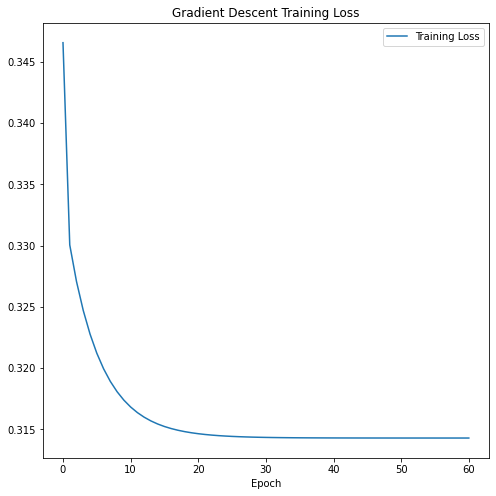

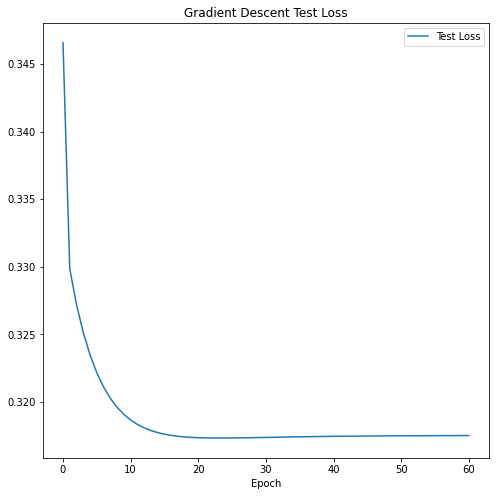

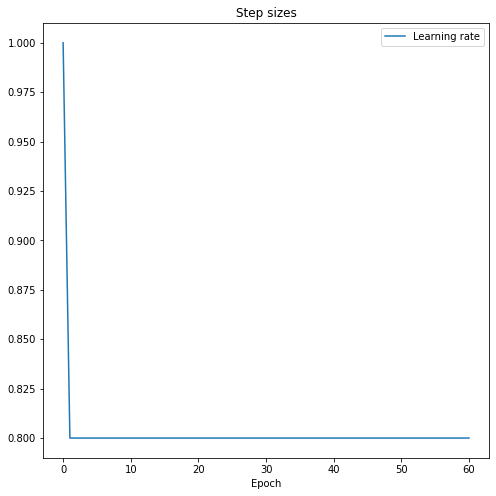

In [46]:

# run GD
gd_gamma = gamma_0
gd_alpha = [alpha0]
gd_train_loss = [loss(gd_gamma, X_train, Y_train, lam)]
gd_test_loss = [loss(gd_gamma, X_test, Y_test, lam)]

for _ in range(epochs):
    gradient = cal_gradient(gd_gamma, X_train_, Y_train, lam)
    alpha = update_alpha(gd_gamma, gradient, X_train, Y_train, lam, gd_alpha[-1])
    gd_gamma = gd_gamma - alpha * gradient
    gd_train_loss.append(loss(gd_gamma, X_train, Y_train, lam))
    gd_test_loss.append(loss(gd_gamma, X_test, Y_test, lam))
    gd_alpha.append(alpha)

# Plot results
plot_result(gd_train_loss, "Training Loss", "Gradient Descent Training Loss")
plot_result(gd_test_loss, "Test Loss", "Gradient Descent Test Loss")
plot_result(gd_alpha, "Learning rate", "Step sizes")
plt.show()

##### Newton's method

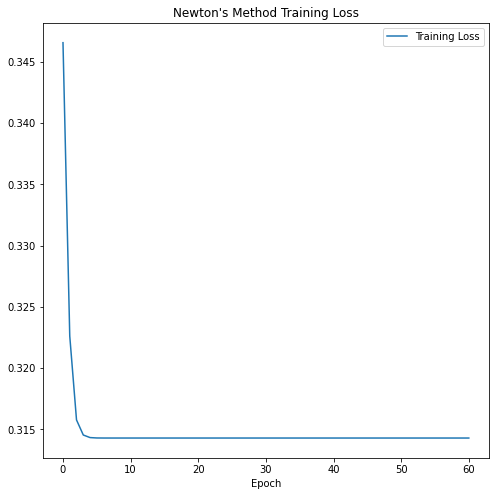

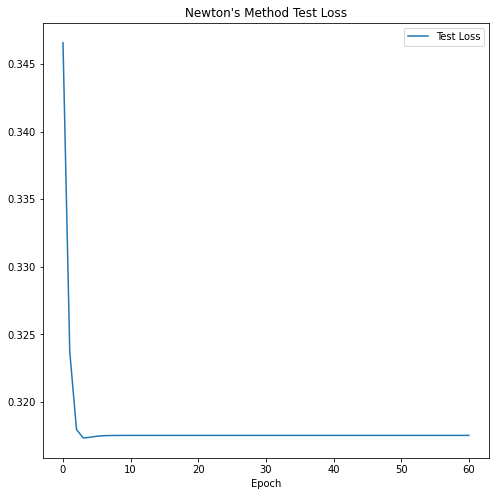

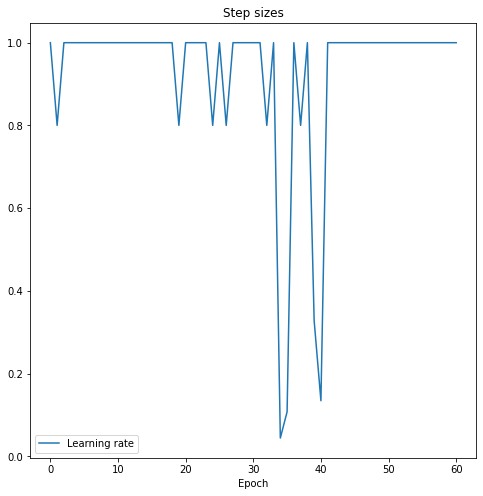

In [49]:
upsilon = np.diag(eta)


def cal_psi(gamma, X):
    return np.diag(cal_P(gamma, X))


def cal_Hessian(gamma, X, lam):
    return upsilon + (lam / n) * X.T @ np.diag(cal_P(gamma, X)) @ X


nt_gamma = gamma_0
nt_alpha = [alpha0]
nt_train_loss = [loss(nt_gamma, X_train, Y_train, lam)]
nt_test_loss = [loss(nt_gamma, X_test, Y_test, lam)]

# Run Newton's method
for _ in range(epochs):
    gradient = cal_gradient(nt_gamma, X_train_, Y_train, lam)
    alpha = update_alpha(nt_gamma, gradient, X_train, Y_train, lam)
    hessian = cal_Hessian(nt_gamma, X_train_, lam)
    nt_gamma = nt_gamma - alpha * np.linalg.inv(hessian) @ gradient
    nt_train_loss.append(loss(nt_gamma, X_train, Y_train, lam))
    nt_test_loss.append(loss(nt_gamma, X_test, Y_test, lam))
    nt_alpha.append(alpha)

# Plot results
plot_result(nt_train_loss, "Training Loss", "Newton's Method Training Loss")
plot_result(nt_test_loss, "Test Loss", "Newton's Method Test Loss")
plot_result(nt_alpha, "Learning rate", "Step sizes")
plt.show()

##### Newton's method vs. GD    

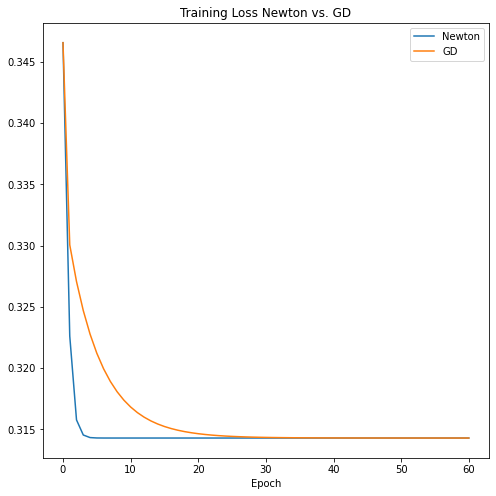

In [50]:
nt_train_loss_df = pd.DataFrame(nt_train_loss, columns=['Newton'])
nt_train_loss_df.plot.line(title="Training Loss Newton vs. GD", xlabel="Epoch")
plt.plot(gd_train_loss, label="GD")
plt.legend()
plt.show()

In general, it turns out that Newton’s method is much better than GD, in fact convergence of the
Newton algorithm is quadratic, whereas convergence of GD is linear (much slower than quadratic).
However, calculating Hessian matrix is difficult, and it can be a costly operation. 
As shown before, the Hessian matrix is a $N\times N$ matrix. 
If the data size increases significantly, it can be so hard or even impossible to compute the Hessian matrix. Newton's method as in the form of this example scales badly. As for GD, we can choose batched GD to deal with enormous data.